# 기본

In [112]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [113]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [114]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [115]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [116]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

In [117]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

In [118]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

In [119]:
level = 85

In [120]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

In [121]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

- 1차원으로 합치기

In [122]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [123]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

- 전용면적별세대수 채우기

In [124]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [125]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [126]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

In [127]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [128]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

In [129]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [130]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

In [131]:
col = ['단지명','도로명주소','subway_name','임대상가']

In [132]:
train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

## 2. 데이터 나누기: 단지내주차면수 987 기준

In [133]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [134]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [135]:
tmp = train[train['단지내주차면수']>=987].reset_index(drop=True)
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

<AxesSubplot:xlabel='등록차량수-총세대수', ylabel='Density'>

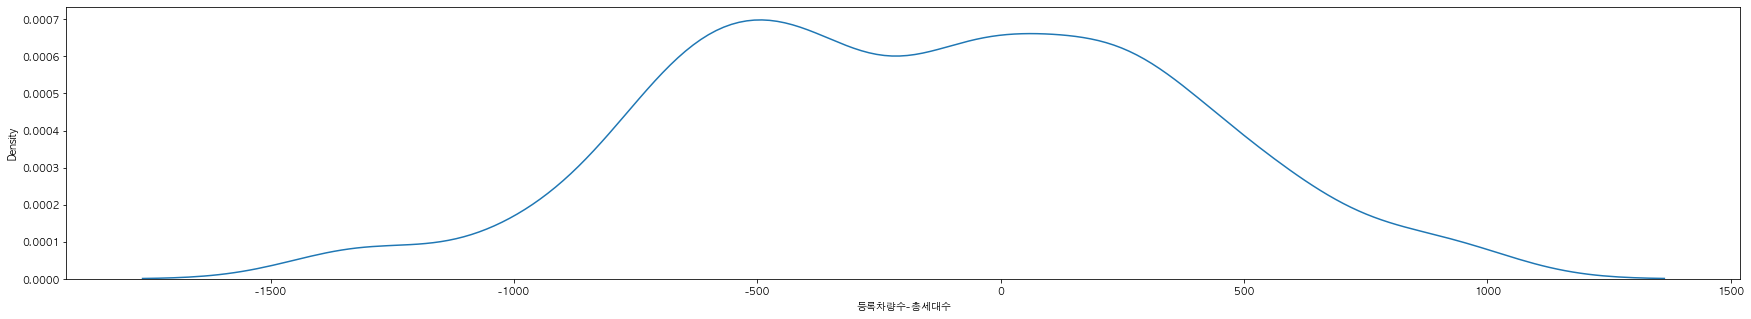

In [136]:
fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-총세대수')

<AxesSubplot:xlabel='지역', ylabel='count'>

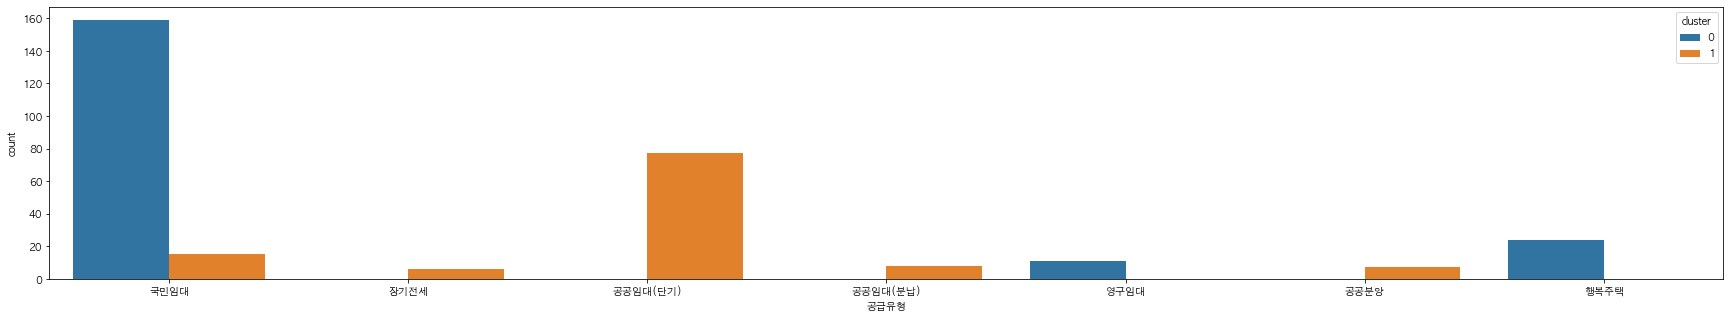

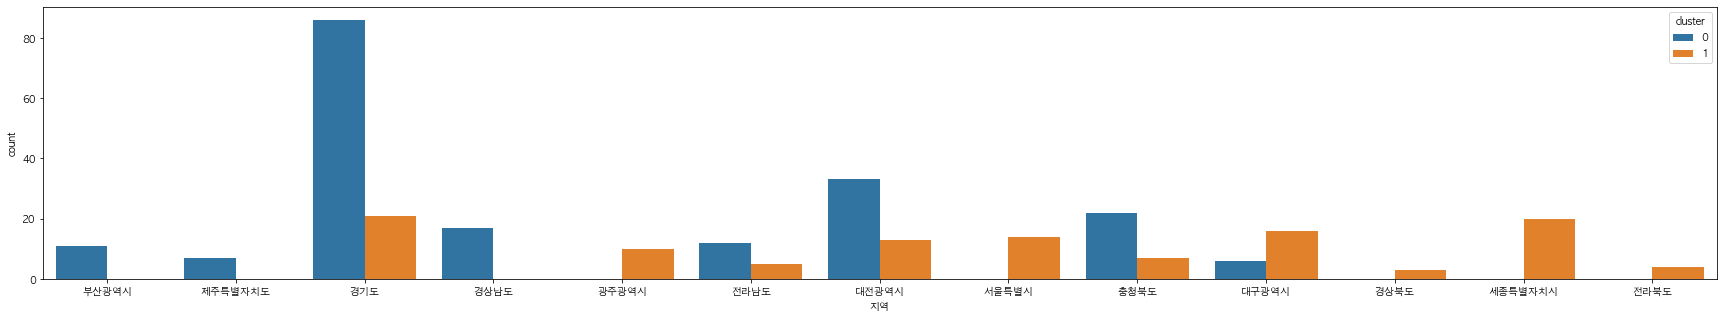

In [137]:
tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]
fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

In [138]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [139]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [140]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

## 3. 모델링

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [83]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [84]:
X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train_down['등록차량수']

In [85]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

In [86]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))

### 2) train/test up

In [87]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율'],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

In [88]:
# plt.figure(figsize=(8,10))
# sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))

## 4. Final prediction

In [142]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [143]:
X_train = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [144]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [145]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']

In [146]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]

cb_up = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train,y_train)
pred_up1 = cb_up.predict(X_test)

In [ ]:
plt.plot()

In [174]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ls_up = Lasso(random_state=2021).fit(X_train,y_train)
pred_up2 = ls_up.predict(X_test)

/Users/seungji/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1414.45008770586, tolerance: 1021.8276230769233
  model = cd_fast.enet_coordinate_descent(


In [176]:
pred_up1

array([1138.76688926, 1324.54982063, 1745.55804792, 1110.85478361,
        864.8864341 , 1454.88173543, 1064.33800305, 1081.15256937,
       1247.70471305, 1037.64613816, 1010.9058185 , 1166.36666485,
       1020.54310649, 1143.76878636, 1189.54972285,  896.3338298 ,
        930.21614202,  907.59404843, 1316.45741053])

In [177]:
pred_up2

array([1052.7511154 , 1072.19998333, 1834.13120023, 1117.4955742 ,
        640.11854719, 1645.2556228 , 1070.6450208 ,  615.92425077,
        918.56810004, 1279.4324861 ,  753.12256307, 1410.92609451,
       1173.55026588, 1260.87102505,  809.87967144, 1078.47715671,
        116.89498427,  465.15474772, 1232.68465813])

In [178]:
tmp = pd.concat([pd.DataFrame(pred_up1),pd.DataFrame(pred_up2)],axis=1)
tmp.columns = ["cat","lasso"]
tmp["pred4:1"] = (tmp["cat"]*4+tmp["lasso"])/5
tmp.sort_values("cat")

,cat,lasso,pred4:1
4,864.886434,640.118547,819.932857
15,896.333830,1078.477157,932.762495
17,907.594048,465.154748,819.106188
16,930.216142,116.894984,767.551910
10,1010.905819,753.122563,959.349167
12,1020.543106,1173.550266,1051.144538
9,1037.646138,1279.432486,1086.003408
6,1064.338003,1070.645021,1065.599407
7,1081.152569,615.924251,988.106906
3,1110.854784,1117.495574,1112.182942


<AxesSubplot:xlabel='cat', ylabel='Density'>

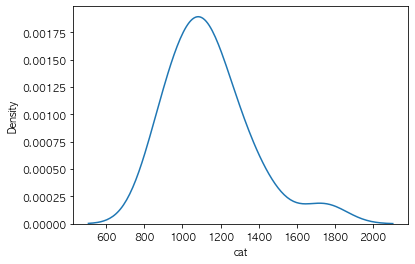

In [151]:
sns.kdeplot(data = tmp,x = "cat")

In [152]:
pred_up = (pred_up1*4+pred_up2)/5
pred_up

array([1121.56373449, 1274.07985317, 1763.27267838, 1112.18294173,
        819.93285672, 1492.95651291, 1065.5994066 ,  988.10690565,
       1181.87739045, 1086.00340775,  959.34916742, 1215.27855078,
       1051.14453837, 1167.1892341 , 1113.61571257,  932.76249518,
        767.55191047,  819.10618829, 1299.70286005])

In [135]:
# pred_up[pred_up2<0] = pred_up1[pred_up2<0]

In [153]:
pred_up

array([1121.56373449, 1274.07985317, 1763.27267838, 1112.18294173,
        819.93285672, 1492.95651291, 1065.5994066 ,  988.10690565,
       1181.87739045, 1086.00340775,  959.34916742, 1215.27855078,
       1051.14453837, 1167.1892341 , 1113.61571257,  932.76249518,
        767.55191047,  819.10618829, 1299.70286005])

In [154]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

In [164]:
tt = [894.0537763454263,
 1141.0017475664274,
 921.7146876657458,
 975.6863725536377,
 854.818720262937,
 1171.0862741640024,
 1063.930998267502,
 923.5229256236207,
 1388.8241376797491,
 1177.756252523328,
 1224.7357229583,
 1520.0490639867294,
 894.1512114347703,
 1476.257382337262,
 1106.4387265041107,
 1076.3641233985263,
 1124.7919216359605,
 1143.4083445208091,
 1078.9108044204806,
 1431.1581395832236,
 789.5793356250945,
 1275.9616021985437,
 1277.5337984017492,
 1087.320215527271,
 1310.4704403434127,
 977.2975223118374,
 922.7397101605659,
 1098.547943561482,
 1224.1217252272615,
 1039.1011243353412,
 990.6011022602535,
 1150.2395577652844,
 1080.743884425129,
 1235.0295546613631,
 1173.8731409592174,
 1290.1743287886266,
 1234.997981855343,
 1009.0184262291689,
 1399.6534365088369,
 1179.5682426224741,
 1586.4977588949412,
 1465.7476899341677,
 1010.3364141497582,
 1489.7502618414683,
 924.3189403689471,
 1298.3959358334935,
 1272.305313964446,
 1200.0970155545642,
 1717.2561748105618,
 1538.7036689518175,
 1447.9681482345063,
 1586.5151069991502]
tt = pd.DataFrame(tt)
tt.columns = ["tt"]

<AxesSubplot:xlabel='x', ylabel='Density'>

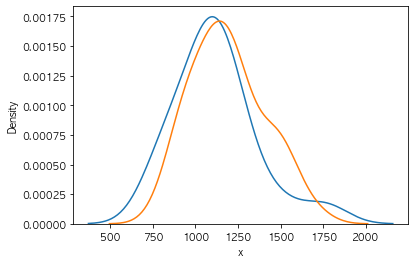

In [165]:
tmpp = pd.DataFrame(pred_up)
tmpp.columns = ["x"]
sns.kdeplot(data = tmpp,x = "x" )
sns.kdeplot(data = tt, x = "tt")

## 5. 기존 score와 비교 및 제출

In [155]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [170]:
sub = submit()
#sub.to_csv("0724__1_4:1.csv",index=False)

In [157]:
get_pred()[2]

,code,num
0,C1072,751.540951
1,C1456,539.409116
2,C1840,533.220234
3,C1640,464.134797
4,C1377,364.187487
...,...,...
142,C1525,1113.615713
143,C2267,932.762495
144,C1692,767.551910
145,C1570,819.106188


In [158]:
def score(mse):
    score = pd.read_csv("Users/seungji/Desktop/Dacon/Daesamanlap/Final/result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [168]:
def score(mse):
    score = pd.read_csv("/Users/seungji/Downloads/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [112]:
# 1:1
res2 = score(96)

전체 MAE :  12.55129822011745
큰 영역 MAE :  97.10741254511896
작은 영역 MAE :  3.68594044175552e-14


In [120]:
# 2:1
res2 = score(96)

전체 MAE :  8.367532146744978
큰 영역 MAE :  64.73827503007932
작은 영역 MAE :  3.68594044175552e-14


In [126]:
# 3:1
res2 = score(96)

전체 MAE :  6.275649110058746
큰 영역 MAE :  48.553706272559516
작은 영역 MAE :  3.68594044175552e-14


In [131]:
# 4:1
res2 = score(96)

전체 MAE :  5.020519288047
큰 영역 MAE :  38.84296501804759
작은 영역 MAE :  3.68594044175552e-14


In [169]:
# 연면적
res2 = score(96)

전체 MAE :  7.7019558446903575
큰 영역 MAE :  59.58881627207777
작은 영역 MAE :  3.68594044175552e-14


In [138]:
# 5:1
res2 = score(96)

전체 MAE :  4.183766073372504
큰 영역 MAE :  32.369137515039654
작은 영역 MAE :  3.68594044175552e-14


In [47]:
res1 = score(98)

전체 MAE :  7.482271233341923
큰 영역 MAE :  57.88915112111887
작은 영역 MAE :  3.0753177782116836e-14
